In [1]:
import numpy as np
import os
from pathlib import Path

import cv2

In [2]:
p = Path("../Dataset/images/")

dirs = p.glob("*")

# initalize dataset
image_data = []
label = []
label_dict = {"cat": 0, "dog": 1, "horse": 2, "human": 3}

for folder in dirs:
    # we get cat...dogs folder location
    image_type = str(folder).split("\\")[-1][:-1]
    image_dir = folder.glob("*.jpg")
    
    for image_loc in image_dir:
        image = cv2.imread(str(image_loc))
        image = cv2.resize(image, (32, 32))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image_data.append(image)
        label.append(label_dict[image_type])

In [3]:
print(len(image_data), len(label))

808 808


In [4]:
image_data = np.array(image_data)
label = np.array(label)

In [5]:
image_data.shape

(808, 32, 32, 3)

## Visualise data

In [6]:
import matplotlib.pyplot as plt
%matplotlib widget

In [7]:
def drawing(img, label):
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
    plt.show()

In [8]:
%matplotlib inline

## shuffle the data

In [9]:
import random

In [10]:
img_label = list(zip(image_data, label))

In [11]:
random.shuffle(img_label)

In [12]:
# unzip
image_data[:], label[:] = zip(*img_label)

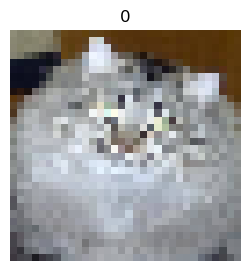

In [13]:
drawing(image_data[2], label[2])

## SVM implementation from scratch

In [28]:
class SVM:
    def __init__(self, c=1.0):
        self.c = c
        self.weight = 0
        self.bias = 0
        
    def loss(X, Y, W, b, c):
        t = Y * (np.dot(X, W) + b)
        l = np.dot(W.T, W) + c * (np.sum(np.maximum(0, 1-t)))
        
        return l
    
    def fit(self, X, Y, batch_size = 60, learning_rate = 0.05, max_epochs = 200):
        Y = Y.reshape((-1, 1))
        
        no_of_samples = Y.shape[0]
        no_of_batch = int(no_of_samples/batch_size)
        no_of_features = X.shape[1]
        
        W = np.zeros((no_of_features, 1))
        b = 0
        
        for i in range(max_epochs):
            for batch_no in range(no_of_batch):
                X_batch = X[batch_no*batch_size: (batch_no+1)*batch_size]
                Y_batch = Y[batch_no*batch_size: (batch_no+1)*batch_size]
                
                t = Y_batch * (np.dot(X_batch, W) + b)
                
                decision = np.zeros(Y_batch.shape)
                decision[t<1] = -1
                
                tXY = np.sum(decision*X_batch*Y_batch, axis=0)
                tXY = tXY.reshape((-1, 1))
                
                gradW = 0.5 * W + self.c  * np.dot(X_batch.T, (decision*Y_batch))
                gradb = self.c * np.dot(decision.T, Y_batch)
                
                W = W - learning_rate * gradW
                b = b - learning_rate * gradb
                
                print(i, batch_no, end="\r")
                
        self.weight = W
        self.bias = b

## data conversion for one-for-one classification

In [15]:
m = image_data.shape[0]
X = image_data.reshape((m, -1))

In [16]:
def typeWiseData(X, Y):
    data = {}
    types = len(np.unique(Y))
    
    for i in range(types):
        data[i] = []
        
    for i in range(X.shape[0]):
        data[Y[i]].append(X[i])
        
    for k in data.keys():
        data[k] = np.array(data[k])
        
    return data

In [17]:
data = typeWiseData(X, label)

In [18]:
print(data[0].shape, data[1].shape, data[2].shape, data[3].shape)

(202, 3072) (202, 3072) (202, 3072) (202, 3072)


In [19]:
def dataPair(d1, d2):
    l1, l2 = d1.shape[0], d2.shape[0]
    
    samples = l1+l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples, features))
    data_pair[:l1, :] = d1
    data_pair[l1:, :] =d2
    
    data_labels = np.ones((samples, 1))
    data_labels[:l1] = -1
    
    return data_pair, data_labels

## Training NC2 SVM's

In [29]:
svc = SVM()

In [30]:
types = len(np.unique(label))

svm_classifier = {}
for i in range(types):
    svm_classifier[i] = {}
    for j in range(i+1, types):
        xpair, ypair = dataPair(data[i], data[j])
        weights, bias, loss = svc.fit(xpair, ypair)
        svm_classifier[i][j] = (weights, bias)

TypeError: cannot unpack non-iterable NoneType object